# Titanic prediction

Keras 入門題目，鐵達尼生存預測  
當作基本的classifier練習

[Titanic competition link](https://www.kaggle.com/c/titanic)




## Step1. 資料載入  
首先把資料集利用pandas抓近來觀察  

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows',10)  

root = os.getcwd()
train_path = os.path.join(root,'titanic/train.csv')
test_path = os.path.join(root,'titanic/test.csv')

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## 資料描述

![](https://i.imgur.com/wYq0bGy.jpg)


這個訓練樣本數不多，只有900筆而已  
把訓練樣本與測試樣本合併，作為觀察與處理  

In [3]:
train_data['test_data'] = 0
test_data['test_data'] = 1
data = train_data.append(test_data,ignore_index=True,sort=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
test_data      1309 non-null int64
dtypes: float64(3), int64(5), object(5)
memory usage: 133.0+ KB


## Step2. 特徵觀察

Deep Learning的訓練結果好壞取決於特徵的選取  
使否有過冗的參數，或是無用的參數，與好的參數留取都是會影響到訓練的結果  
在補上空白值的參數也是提升訓練結果的重要步驟  

需要觀察資料來確認特徵關聯性來決定資料的處理

### 觀察生還與死亡

大約4成的人生存，可以用一般的logistic regresssion來做分類

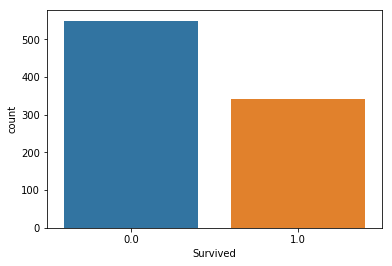

In [4]:
%matplotlib inline
sns.countplot(data['Survived'])

### 觀察性別與生存關係 Sex  

女性生存的機率較高

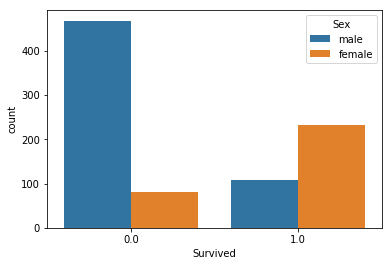

In [5]:
sns.countplot(data['Survived'],hue=data['Sex'])

### 艙等與生存率關係 Pclass
  
三等艙的死亡率較高，二等艙機率持平，一等艙生還率超過死亡率

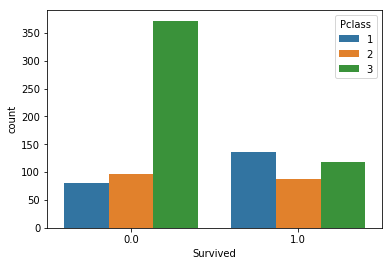

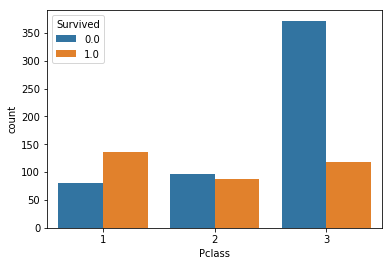

In [6]:
sns.countplot(data['Survived'],hue=data['Pclass'])
plt.figure()
sns.countplot(data['Pclass'],hue=data['Survived'])

### 家庭成員關係 SibSp & Parch

可以看到單身的人其死亡率較高，在有家庭成員下的死亡率趨近於相等
但是觀察性別在單身與否的狀況下發現其結果與觀察死亡性很像

藉由畫出組合的結果，可以發現在單身下，死亡的幾乎為男性
所以家庭成員這項要素可以視為冗餘的參數，暫時不需考慮進模型

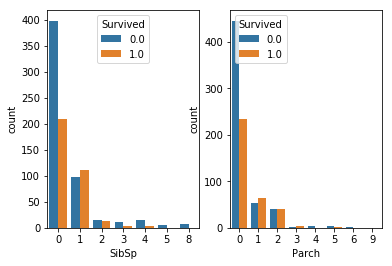

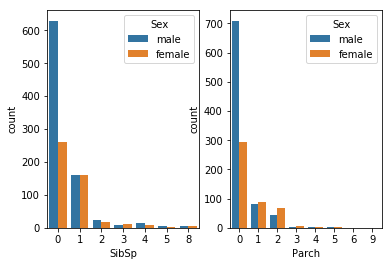

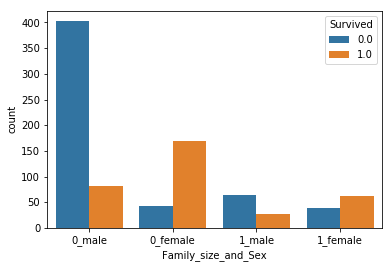

In [7]:
fig, [ax1,ax2] = plt.subplots(1,2)
sns.countplot(data['SibSp'],hue=data['Survived'],ax=ax1)
sns.countplot(data['Parch'],hue=data['Survived'],ax=ax2)


fig, [ax1,ax2] = plt.subplots(1,2)
sns.countplot(data['SibSp'],hue=data['Sex'],ax=ax1)
sns.countplot(data['Parch'],hue=data['Sex'],ax=ax2)


data['Family_size_and_Sex'] = (data['Parch']+data['SibSp']).map(lambda x : 1 if x >1 else 0).astype('str')+'_'+data['Sex']


plt.figure()
sns.countplot(data['Family_size_and_Sex'],hue=data['Survived'])

### 年齡關係 Age

可以觀察到年齡較輕者在生存率上較高

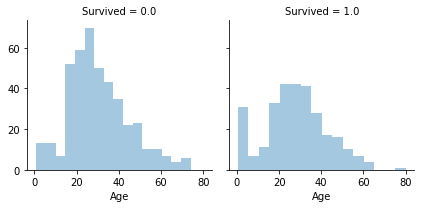

In [8]:
g= sns.FacetGrid(data,col='Survived')
g.map(sns.distplot,'Age',kde=False)

### 票價 Fare

可以票價價低者的死亡率較高

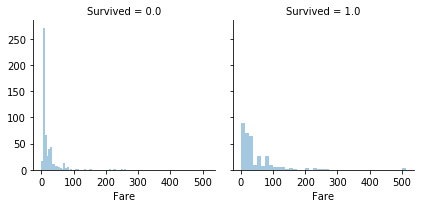

In [9]:
g= sns.FacetGrid(data,col='Survived')
g.map(sns.distplot,'Fare',kde=False)

有一筆缺失值，補上平均數就好  

In [10]:
data.Fare = data.Fare.apply(lambda x: data.Fare.mean() if pd.isnull(x) else x)

### 乘船處 Embarked

乘船處對於死亡率的分布也是有關係的  
但是進一步把每個港口的上船性別分布拆開來看  
其實港口的差別只是因為性別關係帶來的影響  
可以視作這是一個冗餘的參數

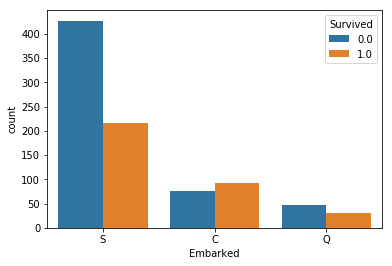

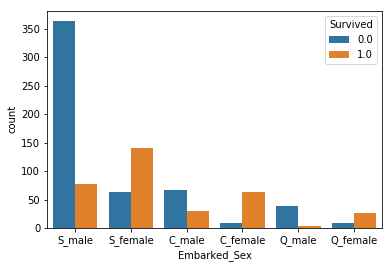

In [11]:
sns.countplot(data['Embarked'],hue=data['Survived'])

data['Embarked_Sex'] = data['Embarked']+'_'+data['Sex']
plt.figure()
sns.countplot(data['Embarked_Sex'],hue=data['Survived'], order=['S_male','S_female','C_male','C_female','Q_male','Q_female'])

### 票等 Pclass
票等在第三艙等也是有較高的死亡率  
進一步分析看看是否又是性別帶出來的結果  
發現在各個票等間，每個性別生存的比例不一樣  

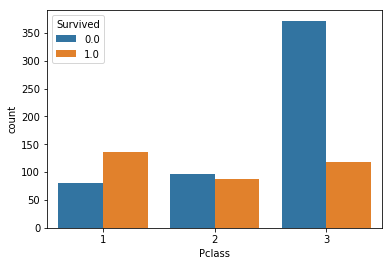

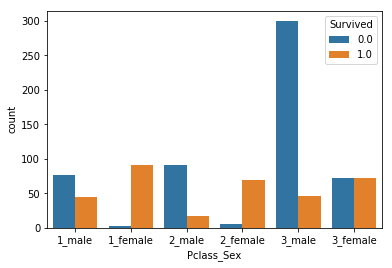

In [12]:
sns.countplot(data['Pclass'],hue=data['Survived'])
data['Pclass_Sex'] = data['Pclass'].astype('str')+'_'+data['Sex']

plt.figure()
sns.countplot(data['Pclass_Sex'],hue=data['Survived'], order=['1_male','1_female','2_male','2_female','3_male','3_female'])

### 艙等 Cabin
艙等的生存分布與性別分布呈現強相關  
而性別的分布又會是生存率分布的強烈因子  
判定這個參數是多餘的  

['NoCabin' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


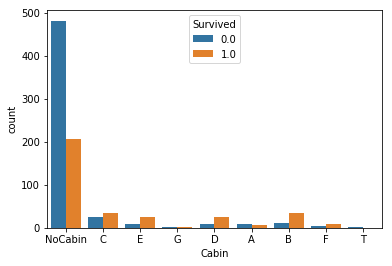

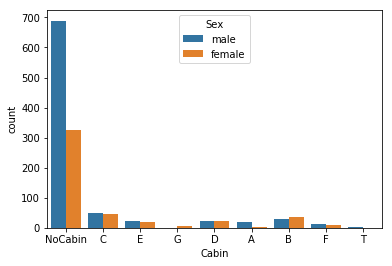

In [13]:
data['Cabin'] = data['Cabin'].apply(lambda x: str(x)[0] if not pd.isnull(x) else 'NoCabin')
print(data['Cabin'].unique())

sns.countplot(data['Cabin'],hue=data['Survived'])
plt.figure()
sns.countplot(data['Cabin'],hue=data['Sex'])

### 姓名 Name

姓名欄內都會有稱謂  
我們知道稱謂與年齡有相關性
因此我們利用稱謂來填補年齡

In [14]:
data['Title']=data['Name'].str.split(', ',n=0,expand=True)[1]
data['Title']=data['Title'].str.split('. ',n=0,expand=True)[0]
map_of_age = dict(data.groupby(['Title'])['Age'].median())
map_of_age

{'Capt': 70.0,
 'Col': 54.5,
 'Don': 40.0,
 'Dona': 39.0,
 'Dr': 49.0,
 'Jonkheer': 38.0,
 'Lady': 48.0,
 'Major': 48.5,
 'Master': 4.0,
 'Miss': 22.0,
 'Mlle': 24.0,
 'Mme': 24.0,
 'Mr': 29.0,
 'Mrs': 35.5,
 'Ms': 28.0,
 'Rev': 41.5,
 'Sir': 49.0,
 'th': 33.0}

In [15]:
for i in range(len(data['Age'])):
    if data.Age.isnull()[i]:
        data.Age[i]=map_of_age[data.Title[i]]


C:\Users\a2720\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### 票根 Ticket

收先觀察Ticket內容  
可以發現有一部分票的內容是重複的  

In [16]:
data['Ticket'].describe()

count         1309
unique         929
top       CA. 2343
freq            11
Name: Ticket, dtype: object

In [53]:
count_of_ticket = dict(data.groupby(['Ticket'])['Ticket'].count())

In [93]:
data['Ticket_group']=0
for i in range(len(data['Ticket'])):
    if count_of_ticket[data.Ticket[i]]>3:
        data.Ticket_group[i]=1

C:\Users\a2720\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Ticket_group
0    1124
1     185
Name: Ticket_group, dtype: int64

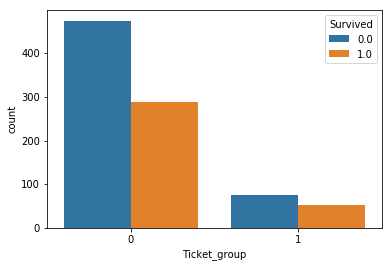

In [94]:
sns.countplot(data['Ticket_group'],hue=data['Survived'])
data.groupby(['Ticket_group'])['Ticket_group'].count()

## Step3. 資料預處理

資料的處理有兩個處理方法  
其一是one hot encoding，如果資料為無序的，就會利用此方法對資料做編碼  
來把資料轉換維n維向量，讓其數據與原點的距離一致。  
  
另一個方法是當資料是有序的時候，直接數值化mapping資料  
讓每筆資料以一個數字表示，這會讓資料與原點距離不同。

把特徵工程觀察的結果處理在我們的資料集上

以下是處理過的原始資料  
要把他轉換成model吃的資料

In [67]:
data.head(10)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,test_data,Family_size_and_Sex,Embarked_Sex,Pclass_Sex,Title,Ticket_group
0,22.0,NoCabin,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,0,0_male,S_male,3_male,Mr,0
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,0,0_female,C_female,1_female,Mrs,0
2,26.0,NoCabin,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,0,0_female,S_female,3_female,Miss,0
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,0,0_female,S_female,1_female,Mrs,0
4,35.0,NoCabin,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,0,0_male,S_male,3_male,Mr,0
5,29.0,NoCabin,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877,0,0_male,Q_male,3_male,Mr,0
6,54.0,E,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,0,0_male,S_male,1_male,Mr,0
7,2.0,NoCabin,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,0,1_male,S_male,3_male,Master,0
8,27.0,NoCabin,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742,0,1_female,S_female,3_female,Mrs,0
9,14.0,NoCabin,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736,0,0_female,C_female,2_female,Mrs,0


In [95]:
train_data = data[data['test_data']==0].iloc[:,0:12]
test_data = data[data['test_data']==1].iloc[:,0:12]

In [96]:
train_data_label = train_data.Survived

train_data = train_data.drop(['Name','Cabin','Embarked','PassengerId','SibSp','Parch','Survived','Ticket'],axis=1)
test_data = test_data.drop(['Name','Cabin','Embarked','PassengerId','SibSp','Parch','Survived','Ticket'],axis=1)

### one_hot_encoding

pandas有很方便的函數  get_dummies  
可以簡單的幫助資料型態轉成one hot的形式  

In [97]:
def one_hot(data, col):
    temp = pd.get_dummies(data[col],prefix=col)
    data = data.drop([col],axis=1)
    data = pd.concat([data,temp],axis=1)
    return data

把sex與pclass轉成one hot

In [98]:
train_data = one_hot(train_data,'Sex')
train_data = one_hot(train_data,'Pclass')
test_data = one_hot(test_data,'Sex')
test_data = one_hot(test_data,'Pclass')

In [99]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 891 to 1308
Data columns (total 7 columns):
Age           418 non-null float64
Fare          418 non-null float64
Sex_female    418 non-null uint8
Sex_male      418 non-null uint8
Pclass_1      418 non-null uint8
Pclass_2      418 non-null uint8
Pclass_3      418 non-null uint8
dtypes: float64(2), uint8(5)
memory usage: 11.8 KB


把ticket group也加入

In [73]:
train_data=pd.concat([train_data,data.Ticket_group],axis=1).dropna()
test_data=pd.concat([test_data,data.Ticket_group],axis=1).dropna()
train_data

,Age,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Ticket_group
0,22.0,7.2500,0.0,1.0,0.0,0.0,1.0,0
1,38.0,71.2833,1.0,0.0,1.0,0.0,0.0,0
2,26.0,7.9250,1.0,0.0,0.0,0.0,1.0,0
3,35.0,53.1000,1.0,0.0,1.0,0.0,0.0,0
4,35.0,8.0500,0.0,1.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...
886,27.0,13.0000,0.0,1.0,0.0,1.0,0.0,0
887,19.0,30.0000,1.0,0.0,1.0,0.0,0.0,0
888,22.0,23.4500,1.0,0.0,0.0,0.0,1.0,0
889,26.0,30.0000,0.0,1.0,1.0,0.0,0.0,0


### normalization

在Deep Learning上，需要把資料縮放到[0,1] 區間  
否則在該參數的梯度下降會被拖累  

In [100]:
def normalization(data, col):
    data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
    return data

In [101]:
train_data = normalization(train_data, 'Age')
train_data = normalization(train_data, 'Fare')
test_data = normalization(test_data, 'Age')
test_data = normalization(test_data, 'Fare')
train_data

,Age,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,0.271174,0.014151,0,1,0,0,1
1,0.472229,0.139136,1,0,1,0,0
2,0.321438,0.015469,1,0,0,0,1
3,0.434531,0.103644,1,0,1,0,0
4,0.434531,0.015713,0,1,0,0,1
...,...,...,...,...,...,...,...
886,0.334004,0.025374,0,1,0,1,0
887,0.233476,0.058556,1,0,1,0,0
888,0.271174,0.045771,1,0,0,0,1
889,0.321438,0.058556,0,1,1,0,0


## Step4. 訓練模型

使用Keras來創建模型  
這裡利用全連結層做11層，最後接上sigmoid利用binary crossentropy做loss function來輸出  

In [104]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()

model.add(Dense(units=128,input_dim=train_data.shape[1],activation='relu',kernel_initializer='normal'))
#model.add(Dropout(0.3))

for _ in range(9):
    model.add(Dense(units=128,activation='relu',kernel_initializer='normal'))
    #model.add(Dropout(0.3))

model.add(Dense(units=1,activation='sigmoid',kernel_initializer='normal'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 128)               1024      
_________________________________________________________________
dense_82 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_83 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_84 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_85 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_86 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_87 (Dense)             (None, 128)               16512     
__________

這裡挑batch_size=100,訓練500次  

In [105]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

train_history= model.fit(x=train_data.values,y=train_data_label,validation_split=0.2,batch_size=100,epochs=500,verbose=2)

Train on 712 samples, validate on 179 samples
Epoch 1/500
 - 1s - loss: 0.6918 - acc: 0.5702 - val_loss: 0.6882 - val_acc: 0.6425
Epoch 2/500
 - 0s - loss: 0.6867 - acc: 0.6096 - val_loss: 0.6736 - val_acc: 0.6425
Epoch 3/500
 - 0s - loss: 0.6642 - acc: 0.6096 - val_loss: 0.5998 - val_acc: 0.6425
Epoch 4/500
 - 0s - loss: 0.6080 - acc: 0.6096 - val_loss: 0.5350 - val_acc: 0.6425
Epoch 5/500
 - 0s - loss: 0.5667 - acc: 0.6096 - val_loss: 0.5198 - val_acc: 0.6425
Epoch 6/500
 - 0s - loss: 0.5557 - acc: 0.6096 - val_loss: 0.5244 - val_acc: 0.6425
Epoch 7/500
 - 0s - loss: 0.5560 - acc: 0.6138 - val_loss: 0.5057 - val_acc: 0.7989
Epoch 8/500
 - 0s - loss: 0.5432 - acc: 0.7837 - val_loss: 0.5300 - val_acc: 0.8101
Epoch 9/500
 - 0s - loss: 0.5529 - acc: 0.7837 - val_loss: 0.5025 - val_acc: 0.7989
Epoch 10/500
 - 0s - loss: 0.5351 - acc: 0.7767 - val_loss: 0.4774 - val_acc: 0.7765
Epoch 11/500
 - 0s - loss: 0.4981 - acc: 0.7683 - val_loss: 0.4502 - val_acc: 0.7989
Epoch 12/500
 - 0s - loss: 0

Epoch 97/500
 - 0s - loss: 0.4315 - acc: 0.7907 - val_loss: 0.3641 - val_acc: 0.8380
Epoch 98/500
 - 0s - loss: 0.4315 - acc: 0.7992 - val_loss: 0.3649 - val_acc: 0.8324
Epoch 99/500
 - 0s - loss: 0.4313 - acc: 0.8020 - val_loss: 0.3643 - val_acc: 0.8268
Epoch 100/500
 - 0s - loss: 0.4288 - acc: 0.8062 - val_loss: 0.3597 - val_acc: 0.8268
Epoch 101/500
 - 0s - loss: 0.4399 - acc: 0.7963 - val_loss: 0.3782 - val_acc: 0.8380
Epoch 102/500
 - 0s - loss: 0.4379 - acc: 0.8020 - val_loss: 0.3601 - val_acc: 0.8268
Epoch 103/500
 - 0s - loss: 0.4312 - acc: 0.8020 - val_loss: 0.3752 - val_acc: 0.8212
Epoch 104/500
 - 0s - loss: 0.4328 - acc: 0.8048 - val_loss: 0.3629 - val_acc: 0.8380
Epoch 105/500
 - 0s - loss: 0.4352 - acc: 0.7935 - val_loss: 0.3646 - val_acc: 0.8268
Epoch 106/500
 - 0s - loss: 0.4285 - acc: 0.7963 - val_loss: 0.3671 - val_acc: 0.8380
Epoch 107/500
 - 0s - loss: 0.4304 - acc: 0.8034 - val_loss: 0.3717 - val_acc: 0.8380
Epoch 108/500
 - 0s - loss: 0.4343 - acc: 0.8034 - val_lo

Epoch 193/500
 - 0s - loss: 0.4276 - acc: 0.7949 - val_loss: 0.3755 - val_acc: 0.8212
Epoch 194/500
 - 0s - loss: 0.4244 - acc: 0.7935 - val_loss: 0.3621 - val_acc: 0.8324
Epoch 195/500
 - 0s - loss: 0.4235 - acc: 0.8034 - val_loss: 0.3910 - val_acc: 0.8324
Epoch 196/500
 - 0s - loss: 0.4298 - acc: 0.8034 - val_loss: 0.3905 - val_acc: 0.8324
Epoch 197/500
 - 0s - loss: 0.4162 - acc: 0.8020 - val_loss: 0.3746 - val_acc: 0.8268
Epoch 198/500
 - 0s - loss: 0.4197 - acc: 0.8076 - val_loss: 0.4788 - val_acc: 0.8268
Epoch 199/500
 - 0s - loss: 0.4262 - acc: 0.7978 - val_loss: 0.3723 - val_acc: 0.8324
Epoch 200/500
 - 0s - loss: 0.4194 - acc: 0.8020 - val_loss: 0.3796 - val_acc: 0.8324
Epoch 201/500
 - 0s - loss: 0.4192 - acc: 0.8034 - val_loss: 0.3612 - val_acc: 0.8268
Epoch 202/500
 - 0s - loss: 0.4223 - acc: 0.8034 - val_loss: 0.3546 - val_acc: 0.8324
Epoch 203/500
 - 0s - loss: 0.4154 - acc: 0.8076 - val_loss: 0.3613 - val_acc: 0.8380
Epoch 204/500
 - 0s - loss: 0.4140 - acc: 0.8034 - val

Epoch 289/500
 - 0s - loss: 0.3984 - acc: 0.8146 - val_loss: 0.3791 - val_acc: 0.8324
Epoch 290/500
 - 0s - loss: 0.3983 - acc: 0.8090 - val_loss: 0.3894 - val_acc: 0.8324
Epoch 291/500
 - 0s - loss: 0.3968 - acc: 0.8090 - val_loss: 0.3893 - val_acc: 0.8324
Epoch 292/500
 - 0s - loss: 0.3945 - acc: 0.8132 - val_loss: 0.3916 - val_acc: 0.8380
Epoch 293/500
 - 0s - loss: 0.3900 - acc: 0.8104 - val_loss: 0.3783 - val_acc: 0.8380
Epoch 294/500
 - 0s - loss: 0.3960 - acc: 0.8118 - val_loss: 0.3812 - val_acc: 0.8324
Epoch 295/500
 - 0s - loss: 0.3888 - acc: 0.8132 - val_loss: 0.3862 - val_acc: 0.8492
Epoch 296/500
 - 0s - loss: 0.3894 - acc: 0.8104 - val_loss: 0.3922 - val_acc: 0.8492
Epoch 297/500
 - 0s - loss: 0.3901 - acc: 0.8076 - val_loss: 0.3877 - val_acc: 0.8324
Epoch 298/500
 - 0s - loss: 0.3940 - acc: 0.8076 - val_loss: 0.3962 - val_acc: 0.8212
Epoch 299/500
 - 0s - loss: 0.4045 - acc: 0.8062 - val_loss: 0.3877 - val_acc: 0.8156
Epoch 300/500
 - 0s - loss: 0.4151 - acc: 0.8076 - val

Epoch 385/500
 - 0s - loss: 0.3967 - acc: 0.8020 - val_loss: 0.3870 - val_acc: 0.8436
Epoch 386/500
 - 0s - loss: 0.3887 - acc: 0.8020 - val_loss: 0.3662 - val_acc: 0.8436
Epoch 387/500
 - 0s - loss: 0.3840 - acc: 0.8020 - val_loss: 0.3868 - val_acc: 0.8436
Epoch 388/500
 - 0s - loss: 0.3859 - acc: 0.8048 - val_loss: 0.3682 - val_acc: 0.8436
Epoch 389/500
 - 0s - loss: 0.3921 - acc: 0.7992 - val_loss: 0.3795 - val_acc: 0.8436
Epoch 390/500
 - 0s - loss: 0.3933 - acc: 0.8062 - val_loss: 0.3970 - val_acc: 0.8436
Epoch 391/500
 - 0s - loss: 0.3838 - acc: 0.8062 - val_loss: 0.3788 - val_acc: 0.8436
Epoch 392/500
 - 0s - loss: 0.3867 - acc: 0.8034 - val_loss: 0.3883 - val_acc: 0.8380
Epoch 393/500
 - 0s - loss: 0.3845 - acc: 0.8090 - val_loss: 0.3824 - val_acc: 0.8324
Epoch 394/500
 - 0s - loss: 0.3910 - acc: 0.8062 - val_loss: 0.3802 - val_acc: 0.8380
Epoch 395/500
 - 0s - loss: 0.3894 - acc: 0.8062 - val_loss: 0.4044 - val_acc: 0.8380
Epoch 396/500
 - 0s - loss: 0.3805 - acc: 0.8076 - val

Epoch 481/500
 - 0s - loss: 0.3834 - acc: 0.8357 - val_loss: 0.3457 - val_acc: 0.8436
Epoch 482/500
 - 0s - loss: 0.4055 - acc: 0.8146 - val_loss: 0.3694 - val_acc: 0.8268
Epoch 483/500
 - 0s - loss: 0.3915 - acc: 0.8272 - val_loss: 0.3244 - val_acc: 0.8547
Epoch 484/500
 - 0s - loss: 0.3821 - acc: 0.8216 - val_loss: 0.3386 - val_acc: 0.8492
Epoch 485/500
 - 0s - loss: 0.3686 - acc: 0.8413 - val_loss: 0.3503 - val_acc: 0.8436
Epoch 486/500
 - 0s - loss: 0.3678 - acc: 0.8483 - val_loss: 0.3501 - val_acc: 0.8436
Epoch 487/500
 - 0s - loss: 0.3775 - acc: 0.8216 - val_loss: 0.3544 - val_acc: 0.8436
Epoch 488/500
 - 0s - loss: 0.3682 - acc: 0.8399 - val_loss: 0.3469 - val_acc: 0.8603
Epoch 489/500
 - 0s - loss: 0.3718 - acc: 0.8329 - val_loss: 0.3732 - val_acc: 0.8324
Epoch 490/500
 - 0s - loss: 0.3715 - acc: 0.8244 - val_loss: 0.3553 - val_acc: 0.8492
Epoch 491/500
 - 0s - loss: 0.3719 - acc: 0.8258 - val_loss: 0.3624 - val_acc: 0.8436
Epoch 492/500
 - 0s - loss: 0.3659 - acc: 0.8413 - val

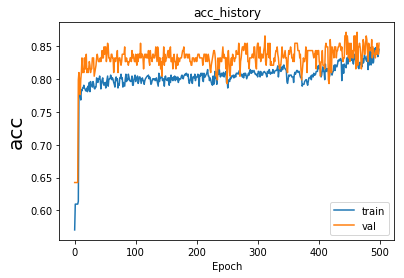

In [106]:
import matplotlib.pyplot as plt

def plot_train_result(train_history,train,val):
    plt.figure()
    plt.plot(train_history.history[train],label='train')
    plt.plot(train_history.history[val],label='val')
    plt.title(train+'_history')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylabel(train,fontsize=20)
    plt.show()

    

plot_train_result(train_history,'acc','val_acc')

## Step5. 儲存結果上傳

In [107]:
result = model.predict_classes(test_data.values)
sub = pd.DataFrame()
sub['PassengerId'] = test_data.index+1
sub['Survived'] = result

sub.shape

(418, 2)

In [108]:
sub.to_csv('titanic_keras_cs2.csv', index=False)